In [1]:
%env "WANDB_NOTEBOOK_NAME" "Playground.ipynb"

env: "WANDB_NOTEBOOK_NAME"="Playground.ipynb"


In [2]:
from multiprocessing import Pool
from pymatgen.io.cif import CifParser
import pandas as pd
from pathlib import Path

def structure_from_cif(cif: str):
    return CifParser.from_str(cif).get_structures()[0]

def read_MP(MP_csv: Path|str):
    MP_df = pd.read_csv(MP_csv, index_col=0)
    with Pool() as pool:
        MP_df["structure"] = pool.map(structure_from_cif, MP_df["cif"])
    MP_df.drop(columns=["cif"], inplace=True)
    return MP_df

In [3]:
datasets_pd = {
    "train": read_MP("cdvae/data/mp_20/train.csv"),
    "test": read_MP("cdvae/data/mp_20/test.csv"),
    "val": read_MP("cdvae/data/mp_20/val.csv")
}

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues

In [4]:
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from collections import Counter
import numpy as np
def structure_to_sites(structure: Structure):
    # Note(kazeevn):
    # We lose information about coordinates (as expected)
    # We also can't disambiguate between different orbits with same site symmetry
    # while the absolute coordinates might depend wholly on the unit cell choice (TBC), relatively to each other they are not
    analyzer = SpacegroupAnalyzer(structure)
    
    symmetry_dataset = analyzer.get_symmetry_dataset()
    # Whitespace usage in site_symmetry_symbols is inconsistent, so we remove it
    orbit_dict = dict(zip(symmetry_dataset['crystallographic_orbits'], map(lambda s: s.replace(" ", ""), symmetry_dataset['site_symmetry_symbols'])))
    element_dict = dict(zip(symmetry_dataset['crystallographic_orbits'], structure.species))
    
    # Sort by electronegativity and then multiplicity
    # The order allows us to do CSP
    mutliplicity = Counter(symmetry_dataset['crystallographic_orbits']).values()
    electronegativity = {orbit: element.X for orbit, element in element_dict.items()}

    order = np.lexsort((list(mutliplicity), list(electronegativity.values())))
    
    return {
        "symmetry_sites": [list(orbit_dict.values())[i] for i in order],
        "symmetry_elements": [list(element_dict.values())[i] for i in order],
        "spacegroup_number": analyzer.get_space_group_number(),
    }

In [5]:
for dataset in datasets_pd.values():
    with Pool() as p:
        symmetry_dataset = pd.DataFrame.from_records(p.map(structure_to_sites, dataset['structure'])).set_index(dataset.index)
    dataset.loc[:, symmetry_dataset.columns] = symmetry_dataset

spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 2 tolerance = 9.025000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 3 tolerance = 8.573750e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 4

In [6]:
# Pad the lists to ease the batching
# Maybe in the future we should use NestedTensor or EncoderLayer's buit-in padding
from pymatgen.core import DummySpecie
from itertools import chain
from operator import itemgetter
max_len = max(map(len, chain.from_iterable(map(itemgetter("symmetry_sites"), datasets_pd.values())))) + 1
for dataset in datasets_pd.values():
    dataset['symmetry_sites_padded'] = [x + ["STOP"] + ["PAD"] * (max_len - len(x)) for x in dataset['symmetry_sites']]
    dataset['symmetry_elements_padded'] = [x + ["STOP"] + [DummySpecie()] * (max_len - len(x)) for x in dataset['symmetry_elements']]
    dataset['padding_mask'] = [[False] * (len(x) + 1) + [True] * (max_len - len(x)) for x in dataset['symmetry_sites']]
print(max_len)

21


In [7]:
all_sites = set(chain.from_iterable(chain(*map(itemgetter("symmetry_sites_padded"), datasets_pd.values()))))
all_elements = set(chain.from_iterable(chain(*map(itemgetter("symmetry_elements_padded"), datasets_pd.values()))))
all_spacegroups = set(chain(*map(itemgetter("spacegroup_number"), datasets_pd.values())))
# In order to make conditional prediction of sites on elements, we need to make a predicion of site by
# N sites, and (N+1) elements
MASK_SITE = "MASK_SITE"
all_sites.add(MASK_SITE)

In [8]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [9]:
site_to_ids = {word: idx for idx, word in enumerate(all_sites)}
element_to_ids = {word: idx for idx, word in enumerate(all_elements)}
spacegroup_to_ids = {word: idx for idx, word in enumerate(all_spacegroups)}
MASK_ID = site_to_ids[MASK_SITE]
def sites_to_tensor(sites):
    return torch.tensor([site_to_ids[site] for site in sites])
def element_to_tensor(elements):
    return torch.tensor([element_to_ids[element] for element in elements])
def spacegroup_to_tensor(spacegroup):
    return torch.tensor(spacegroup_to_ids[spacegroup])
for dataset in datasets_pd.values():
    dataset['symmetry_sites_tensor'] = dataset['symmetry_sites_padded'].map(sites_to_tensor)
    dataset['symmetry_elements_tensor'] = dataset['symmetry_elements_padded'].map(element_to_tensor)
    dataset['spacegroup_number_tensor'] = dataset['spacegroup_number'].map(spacegroup_to_tensor)
    dataset['padding_mask_tensor'] = dataset['padding_mask'].map(torch.tensor)

In [10]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class WyckoffTransformerModel(nn.Module):

    def __init__(self, n_space_groups: int, n_sites: int, n_elements: int, d_space_groups: int, d_sites: int, d_species: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        # We are going to concatenate the site, the element, and the space group
        self.d_model = d_sites + d_species + d_space_groups
        self.n_token = n_sites + n_elements
        self.n_elements = n_elements
        encoder_layers = TransformerEncoderLayer(self.d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.sites_embedding = nn.Embedding(n_sites, d_sites)
        self.species_embedding = nn.Embedding(n_elements, d_species)
        self.space_groups_embedding = nn.Embedding(n_space_groups, d_space_groups)
        # We predict both the site and the element
        # However! They can not be sampled independently!
        # We are going to condition site on the element,
        # so that we can attempt CSP
        # The question of autoregressive construction order is still open though
        # An option would be to first sort by element, and then by site multiplicity
        self.linear = nn.Linear(self.d_model, self.n_token)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # CONSIDER(kazeevn) using the site symmetry matrices to initialize the site embeddings
        # and some inforamtion about the element to initialize the element embeddings
        self.sites_embedding.weight.data.uniform_(-initrange, initrange)
        self.species_embedding.weight.data.uniform_(-initrange, initrange)
        self.space_groups_embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self,
                space_group: Tensor,
                sites: Tensor,
                species: Tensor,
                padding_mask: Tensor) -> (Tensor, Tensor):
        """
        Arguments:
            space_group: Tensor of shape ``[batch_size]``
            sites: Tensor, shape ``[seq_len, batch_size]``
            species: Tensor, shape ``[seq_len, batch_size]``

        Returns:
            Tensor of shape ``[seq_len, batch_size, n_elements]``
            Tensor of shape ``[seq_len, batch_size, n_sites]``
            Remember not to train via independent sampling!
        """
        # And here is a good question on masking
        # 1. Padding. If we just mask it, the model won't be able to stop predicting, we'll need to additinally introduce a stop token.
        # probably, can do without for now. The previous iteration reliably predicted sequences of PADs
        # 2. Casual masking. We can't use it as is, as we need the model to attend on the element of the site
        # 3. While we output the whole sequence, we should only train on the last element, as we use MASK for marking the site under prediction
        # and since we do incremental batching, using the previous elements multiple time would unjustly increase their weight
        src = torch.concat([self.sites_embedding(sites), self.species_embedding(species),
                            self.space_groups_embedding(torch.tile(space_group, (sites.shape[0], 1)))], dim=2) * math.sqrt(self.d_model)
        output = self.transformer_encoder(src, src_key_padding_mask=padding_mask)
        output = self.linear(output)
        return output[:, :, :self.n_elements], output[:, :, self.n_elements:]

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def to_combined_dataset(dataset):
    return dict(
        symmetry_sites=torch.stack(dataset['symmetry_sites_tensor'].to_list()).T.to(device),
        symmetry_elements=torch.stack(dataset['symmetry_elements_tensor'].to_list()).T.to(device),
        spacegroup_number=torch.stack(dataset['spacegroup_number_tensor'].to_list()).to(device),
        padding_mask = torch.stack(dataset['padding_mask_tensor'].to_list()).to(device)
    )
torch_datasets = dict(zip(datasets_pd.keys(), map(to_combined_dataset, datasets_pd.values())))

In [12]:
MASK_ID_TENSOR = torch.tensor(MASK_ID).to(device)
ELEMENT_PAD_ID_TENSOR = torch.tensor(element_to_ids[DummySpecie()]).to(device)
def get_batches(symmetry_sites: Tensor, symmetry_elements:Tensor, element_seq_len: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        element_seq_len: number of elements considered known
    Returns:
        Two tuples of (data, target, padding_mask):
        1. The first is to predict the element given i sites and elements
        2. The second is to predict the site given i sites and i+1 elements
        
    """
    # Can't predict past the last token
    assert element_seq_len < symmetry_elements.shape[0]
    # Predict element number element_seq_len + 1
    data_element = {
        "sites": symmetry_sites[0:element_seq_len],
        "species": symmetry_elements[0:element_seq_len]
    }
    target_element = symmetry_elements[element_seq_len]

    # Predict site number element_seq_len + 1
    # For sites, we condition on species, hence the + 1  in species
    data_site = {
        "sites": torch.cat([symmetry_sites[0:element_seq_len], MASK_ID_TENSOR.expand(1, symmetry_sites.shape[1])], dim=0),
        "species": symmetry_elements[0:element_seq_len + 1]
    }
    target_site = symmetry_sites[element_seq_len]
    return ((data_element, target_element), (data_site, target_site))

In [13]:
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 4  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 4  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
n_space_groups = len(all_spacegroups)
# Nope, not all SGs are present
# assert n_space_groups == 230
model = WyckoffTransformerModel(
    n_space_groups = n_space_groups,
    n_sites = len(site_to_ids),
    n_elements = len(element_to_ids),
    d_space_groups = 16,
    d_sites = 64,
    d_species = 64,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout).to(device)

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
import wandb

In [15]:
bptt = max_len

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def get_loss(model, dataset, known_seq_len):
    (data_element, target_element), (data_site, target_site) = get_batches(dataset["symmetry_sites"],
                                                                           dataset["symmetry_elements"], known_seq_len)
    output_element = model(dataset["spacegroup_number"], **data_element,
                           padding_mask=dataset["padding_mask"][:, :known_seq_len])[0]
    loss_element = criterion(output_element[-1, :, :], target_element)
    output_site = model(dataset["spacegroup_number"], **data_site,
                        padding_mask=dataset["padding_mask"][:, :known_seq_len + 1])[1]
    loss_site = criterion(output_site[-1, :, :], target_site)
    loss = loss_element + loss_site
    return loss

def train(model: nn.Module) -> None:
    model.train()
    this_epoch_loss = 0
    
    for known_seq_len in range(1, max_len):
        loss = get_loss(model, torch_datasets["train"], known_seq_len)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        lr = scheduler.get_last_lr()[0]
        wandb.log({"train_loss_batch": loss})
        this_epoch_loss += loss.item()
    return this_epoch_loss / (max_len - 1)
        

def evaluate(model: nn.Module) -> float:
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for known_seq_len in range(1, max_len):
            loss = get_loss(model, torch_datasets["val"], known_seq_len)
            total_loss += loss
    return total_loss / (max_len - 1)
    # TODO Stop/PAD handling in loss            

In [36]:
import pathlib
import datetime
best_val_loss = float('inf')
epochs = 100
train_model = True
if train_model:
    run_path = pathlib.Path("checkpoints", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    run_path.mkdir(parents=True)
    best_model_params_path = os.path.join(run_path, "best_model_params.pt")

    with wandb.init(project="WyckoffTransformer"):
        wandb.define_metric("epoch")
        wandb.define_metric("train_loss_epoch", step_metric="epoch")
        wandb.define_metric("val_loss_epoch", step_metric="epoch")
        for epoch in range(1, epochs + 1):
            train_loss_epoch = train(model)
            val_loss_epoch = evaluate(model).item()
            wandb.log({"val_loss_epoch": val_loss_epoch, "train_loss_epoch": train_loss_epoch, "epoch": epoch})
            if val_loss_epoch < best_val_loss:
                best_val_loss = val_loss_epoch
                torch.save(model.state_dict(), best_model_params_path)
            scheduler.step()
        wandb.save(best_model_params_path)
else:
    best_model_params_path = "checkpoints/2023-11-28_16-11-06/best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path))

checkpoints/2023-11-28_16-11-06/best_model_params.pt


<All keys matched successfully>

In [17]:
from torch.nn.functional import softmax
model.eval()
space_groups = torch_datasets["test"]["spacegroup_number"]
sites = torch_datasets["test"]["symmetry_sites"][[0]]
elements = torch_datasets["test"]["symmetry_elements"][[0]]
for i in range(max_len - 1):
    probas_elements = softmax(model(space_groups, sites, elements, None)[0], -1)
    next_elemenets = torch.multinomial(probas_elements[-1], 1).T
    elements = torch.cat((elements, next_elemenets), 0)

    masked_sites = torch.cat([sites, MASK_ID_TENSOR.expand(1, sites.shape[1])], dim=0)
    probas_sites = softmax(model(space_groups, masked_sites, elements, None)[1], -1)
    next_sites = torch.multinomial(probas_sites[-1], 1).T
    sites = torch.cat((sites, next_sites), 0)

In [18]:
idx_to_element = {idx: element for element, idx in element_to_ids.items()}
idx_to_site = {idx: site for site, idx in site_to_ids.items()}
idx_to_spacegroup = {idx: spacegroup for spacegroup, idx in spacegroup_to_ids.items()}

In [19]:
PAD_ID = site_to_ids["PAD"]
STOP_ID = site_to_ids["STOP"]
ELEMENT_PAD_ID = element_to_ids[DummySpecie()]
ELEMENT_STOP_ID = element_to_ids["STOP"]

In [20]:
generated_structuers = []
for this_elements, this_sites, this_spacegroup in zip(elements.T, sites.T, space_groups):
    sites_str = []
    elements_str = []
    for i in range(len(this_sites)):
      if this_sites[i] in (PAD_ID, STOP_ID) or this_elements[i] in (ELEMENT_PAD_ID, ELEMENT_STOP_ID):
        break
      sites_str.append(idx_to_site[int(this_sites[i])])
      elements_str.append(idx_to_element[int(this_elements[i])])
    generated_structuers.append({
        "spacegroup": int(idx_to_spacegroup[int(this_spacegroup)]),
        "sites": sites_str,
        "elements": elements_str
    })

In [21]:
all_datasets = pd.concat(datasets_pd.values())

In [22]:
from collections import defaultdict
from pyxtal.symmetry import Group
index = dict()
wp_index = defaultdict(dict)
from collections import defaultdict
all_sites = defaultdict(set)
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()  
        normalised_ss = wp.site_symm.replace(" ", "")
        all_sites[normalised_ss].add(group_number)
        wp_index[group_number][normalised_ss] = (wp.multiplicity, wp.letter)

In [23]:
# Spglib and pyxtal use a different notation for the same space groups
def update_db(site, group):
    if site in wp_index[group] and wp_index[group][site] is None:
        raise KeyError("Site previously not found")
    
    example_records = all_datasets[all_datasets.spacegroup_number == group]
    example_records = example_records[example_records.symmetry_sites.apply(lambda x: site in x)]
    if len(example_records) == 0:
        wp_index[group][site] = None
        raise KeyError("Site previously not found")
    record = example_records.iloc[0]
    example_record = SpacegroupAnalyzer(record["structure"]).get_symmetry_dataset()
    offending_site_index = example_record["site_symmetry_symbols"].index(site)
    offending_site_wp = example_record["wyckoffs"][offending_site_index]

    offending_site_multiplicity = Counter(example_record["crystallographic_orbits"])[
                                            example_record["crystallographic_orbits"][offending_site_index]]
    wp_index[group][site] = (offending_site_multiplicity, offending_site_wp)

In [24]:
import pyxtal
generator = pyxtal.pyxtal()

In [25]:
total = 0
valid = 0
valid_structures = []
for example in generated_structuers:
    total += 1
    T_sites_list = []
    try:
        mutliplicity = []
        for site, element in zip(example['sites'], example['elements']):
            if site not in wp_index[example["spacegroup"]]:
                update_db(site, example["spacegroup"])
            if wp_index[example["spacegroup"]][site] is None:
                raise KeyError("Site not found in the group")
            mutliplicity.append(wp_index[example["spacegroup"]][site][0])
            T_sites_list.append([str(wp_index[example["spacegroup"]][site][0])+wp_index[example["spacegroup"]][site][1]])
        valid += 1
        T_spacegroup = example['spacegroup']
        valid_structures.append({
            "spacegroup": T_spacegroup,
            "sites": T_sites_list,
            "elements": list(map(str, example['elements'])),
            "multiplicity": mutliplicity
        })
    except KeyError:
        #raise
        print(example)
        pass

{'spacegroup': 194, 'sites': ['3m.', '.3m', '.3.', '-1'], 'elements': [Element Ga, Element Ga, Element Ga, Element Sn]}
{'spacegroup': 160, 'sites': ['3m', '-3.', '-3.', '-3.', '-3.', '-3m', '-3.', '-3.', '-3.', '-3m', '-3.', '-3.'], 'elements': [Element Sm, Element Tm, Element La, Element Ca, Element Tl, Element Tl, Element Te, Element Cl, Element Cl, Element Cl, Element Cl, Element Cl]}
{'spacegroup': 65, 'sites': ['mmm', '-3m.', '4/mmm'], 'elements': [Element Cu, Element F, Element F]}
{'spacegroup': 8, 'sites': ['m', '3..', '.2/m', '32', '.-3m'], 'elements': [Element Na, Element Tl, Element V, Element O, Element O]}
{'spacegroup': 8, 'sites': ['m', '-42.m', 'm.mm'], 'elements': [Element Ho, Element Zn, Element N]}
{'spacegroup': 18, 'sites': ['..2', '2mm', '-4m.2', '.-3m', '.-3m', '4/mmm'], 'elements': [Element Li, Element Y, Element Fe, Element P, Element O, Element O]}
{'spacegroup': 12, 'sites': ['2/m', 'mmm'], 'elements': [Element Fe, Element Ar]}
{'spacegroup': 12, 'sites': ['

In [26]:
print(valid, total)

1132 9046


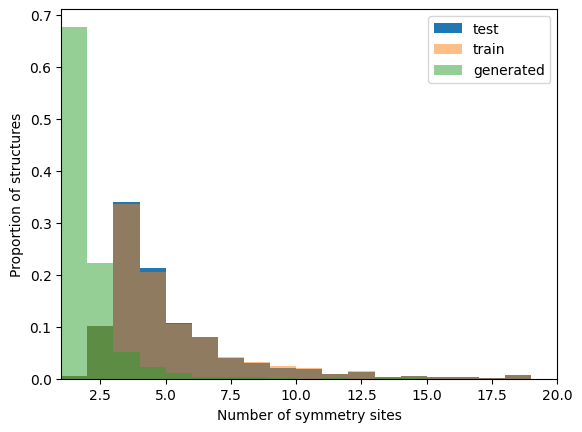

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(1, max_len - 1)
ax.hist(datasets_pd['test'].symmetry_sites.map(len), label="test", density=True, bins=x)
ax.hist(datasets_pd['train'].symmetry_sites.map(len), label="train", density=True, alpha=0.5, bins=x)
ax.hist(list(map(lambda s: len(s["elements"]), valid_structures)), label="generated", density=True, alpha=0.5, bins=x)
ax.set_xlabel("Number of symmetry sites")
ax.set_ylabel("Proportion of structures")
ax.legend()
ax.set_xlim(1, max_len - 1);

In [28]:
def count_elements(record):
    return len(set(record["elements"]))

In [29]:
def count_elements_pd(record):
    return len(set(record.structure.elements))

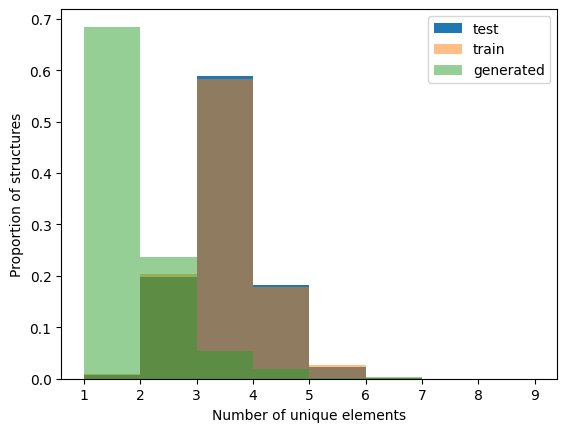

In [30]:
fig, ax = plt.subplots()
bins = np.arange(1, 10)
ax.hist(datasets_pd['test'].apply(count_elements_pd, axis=1), label="test", density=True, bins=bins)
ax.hist(datasets_pd['train'].apply(count_elements_pd, axis=1), label="train", density=True, alpha=0.5, bins=bins)
ax.hist(list(map(count_elements, valid_structures)), label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Proportion of structures")
ax.legend();

In [31]:
# TODO pass tm and consider learning it
# Consider 1.5*covalent
example = valid_structures[0]
generator.from_random(3, group=example["spacegroup"], species=example["elements"],
                      numIons=example["multiplicity"], sites=example["sites"])

In [32]:
example

{'spacegroup': 194, 'sites': [['4e']], 'elements': ['Zr'], 'multiplicity': [4]}

In [33]:
Group(160)

-- Spacegroup --# 160 (R3m)--
18c	site symm: 1
9b	site symm: . . m
3a	site symm: 3 m .

In [34]:
ase_struct = generator.to_ase()

In [35]:
import ase.visualize
ase.visualize.view(ase_struct, viewer="ngl")